# Chargement des données

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
import sys
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


df = pd.read_csv('./data/transaction_data.csv', sep=';', parse_dates=True)
data = df.values
days = np.unique(data[:,2])
ts = []
for d in days:
    ts.append(np.sum(np.multiply(data[np.where(data[:,2]==d)[0],4],data[np.where(data[:,2]==d)[0],5])))
del ts[-1]
del ts[-1]

/home/ccs/anaconda3/envs/my_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Visualisation

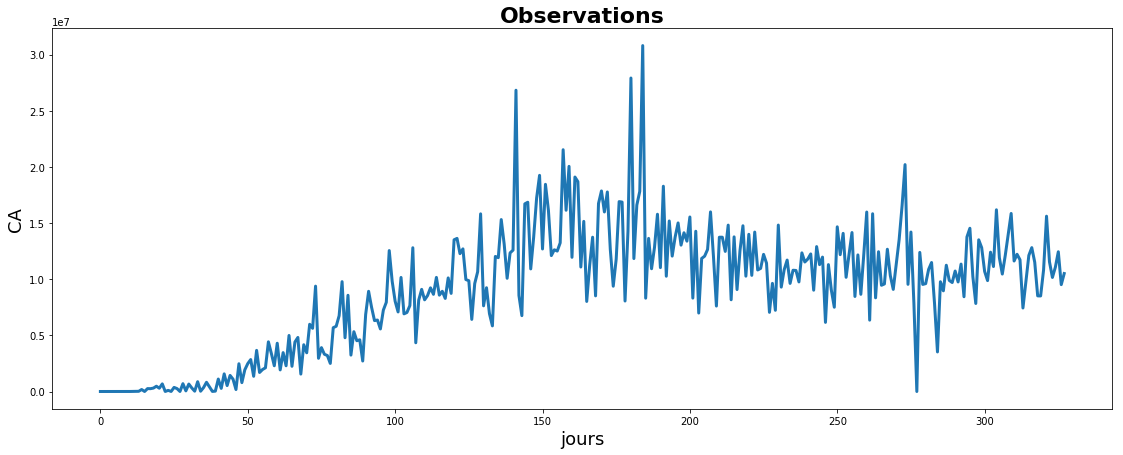

In [2]:
fig = plt.figure(figsize=(19, 7))
plt.plot(ts, linewidth=3)
plt.title('Observations', fontsize=22, fontweight="bold")
plt.xlabel('jours', fontsize=18)
plt.ylabel('CA', fontsize=18)
plt.savefig('./images/observation.png')

# ARIMA

In [5]:
# SARIMAX
mdl = sm.tsa.statespace.SARIMAX(ts,order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()
print(res.summary())

                            Statespace Model Results                           
Dep. Variable:                       y   No. Observations:                  328
Model:             SARIMAX(2, 2, 1, 7)   Log Likelihood               -5201.557
Date:                 Mon, 04 Jun 2018   AIC                          10411.113
Time:                         12:29:15   BIC                          10426.111
Sample:                              0   HQIC                         10417.106
                                 - 328                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.4864      0.071     -6.865      0.000      -0.625      -0.348
ar.S.L14      -0.3030      0.062     -4.867      0.000      -0.425      -0.181
ma.S.L7       -0.9481      0.061    -15.578 

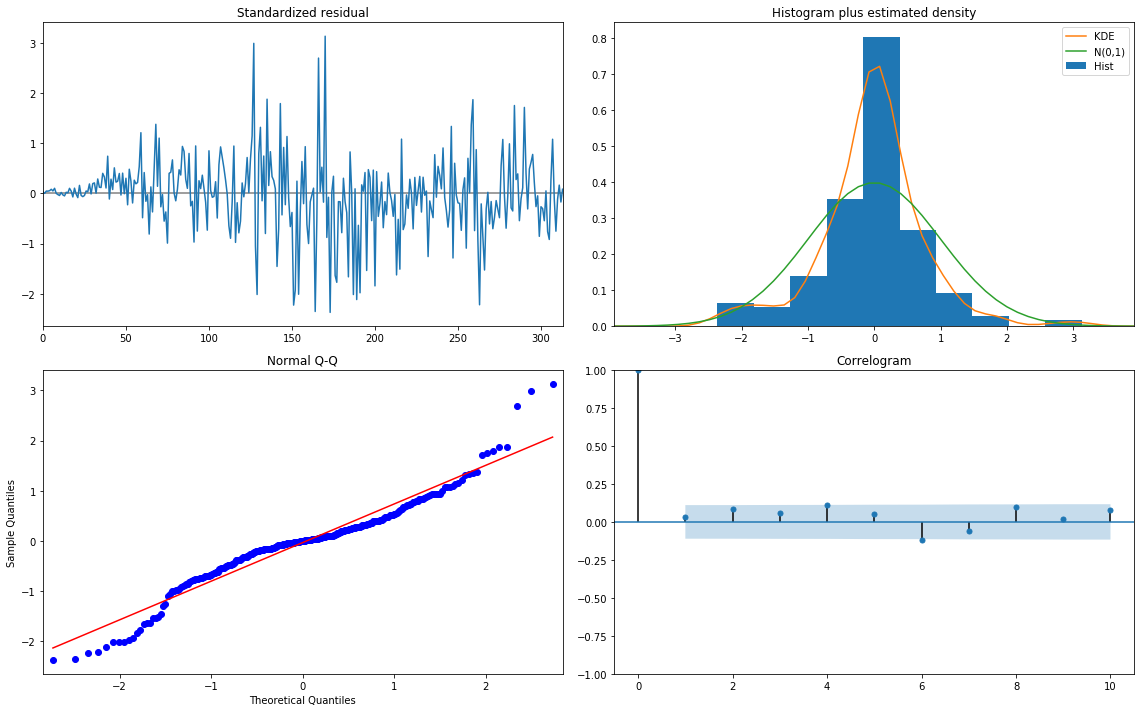

In [4]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

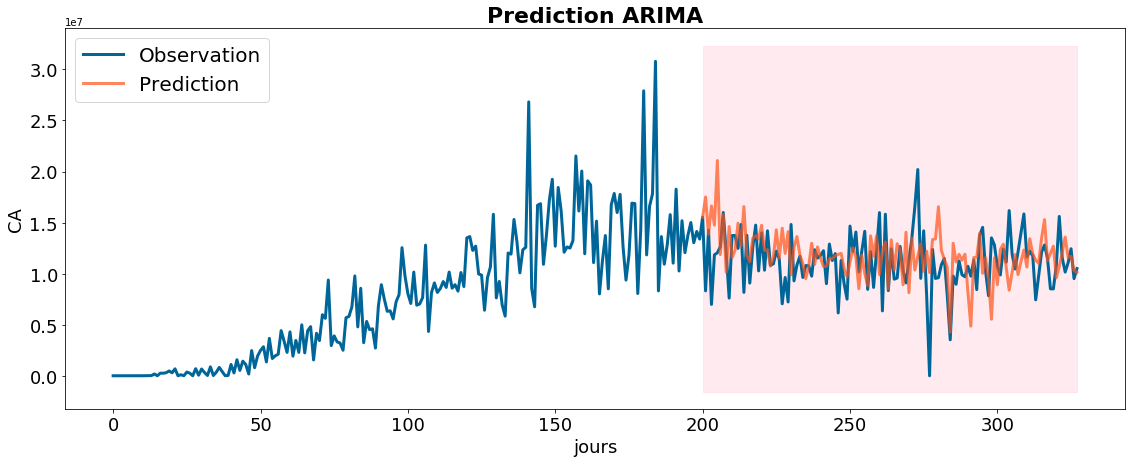

rmse = 3447235.0291836774


In [5]:
y = pd.DataFrame(ts)

# fit model to data
res = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start = 200, 
                          end = 327,
                          dynamic = False, 
                          full_results=True)
# plot in-sample-prediction
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(y[0:],color='#006699',linewidth = 3, label='Observation');
pred.predicted_mean.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.fill_betweenx(ax.get_ylim(), 200, y.index[-1], alpha=.3, zorder=-1, color='pink');
ax.set_xlabel('jours', fontsize=18)
ax.set_ylabel('CA', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction ARIMA', fontsize=22, fontweight="bold")
plt.savefig('./images/PredictionARIMA.png')
plt.show()


rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - y[200:].values) ** 2).mean())
print('rmse = '+ str(rmse))

## RNN

In [6]:
#train = ts[0:200]
#test = ts[200:]

train = ts[0:190]
test = ts[190:]

In [7]:
def preparation_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags)]
        X.append(a)
        y.append(data[row + lags])
    return np.array(X), np.array(y)

In [8]:
lags = 10
X_train, y_train = preparation_data(train, lags)
X_test, y_test = preparation_data(test, lags)

mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)
 
train_score = mdl.evaluate(X_train, y_train, verbose=0)
test_score = mdl.evaluate(X_test, y_test, verbose=0)

train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)


Epoch 1/400
 - 0s - loss: 12054157040297.4746
Epoch 2/400
 - 0s - loss: 11658690082606.8438
Epoch 3/400
 - 0s - loss: 11687091456011.4414
Epoch 4/400
 - 0s - loss: 11590105098608.9824
Epoch 5/400
 - 0s - loss: 11341773080089.7422
Epoch 6/400
 - 0s - loss: 11383521245035.2617
Epoch 7/400
 - 0s - loss: 11501309713179.1738
Epoch 8/400
 - 0s - loss: 11150915010139.5312
Epoch 9/400
 - 0s - loss: 11360172544263.1523
Epoch 10/400
 - 0s - loss: 11079979771629.4082
Epoch 11/400
 - 0s - loss: 11001470789242.9941
Epoch 12/400
 - 0s - loss: 10883962309900.8711
Epoch 13/400
 - 0s - loss: 10924240230016.7148
Epoch 14/400
 - 0s - loss: 10935498202914.5918
Epoch 15/400
 - 0s - loss: 10770734976703.6426
Epoch 16/400
 - 0s - loss: 10746542105890.5918
Epoch 17/400
 - 0s - loss: 10696694476707.0391
Epoch 18/400
 - 0s - loss: 10696283017948.2461
Epoch 19/400
 - 0s - loss: 10623680803774.2129
Epoch 20/400
 - 0s - loss: 10607112104771.2188
Epoch 21/400
 - 0s - loss: 10596517069154.6816
Epoch 22/400
 - 0s - l

Epoch 177/400
 - 0s - loss: 8871573919034.3457
Epoch 178/400
 - 0s - loss: 8912581169471.6426
Epoch 179/400
 - 0s - loss: 9225779560419.3965
Epoch 180/400
 - 0s - loss: 8785600436105.2959
Epoch 181/400
 - 0s - loss: 8808409625874.5918
Epoch 182/400
 - 0s - loss: 8940496108875.7988
Epoch 183/400
 - 0s - loss: 9061985444405.8105
Epoch 184/400
 - 0s - loss: 8833755614069.2734
Epoch 185/400
 - 0s - loss: 8999488280292.6484
Epoch 186/400
 - 0s - loss: 8941951090188.8711
Epoch 187/400
 - 0s - loss: 9060002102040.3125
Epoch 188/400
 - 0s - loss: 8912074943073.2520
Epoch 189/400
 - 0s - loss: 8863963214968.1348
Epoch 190/400
 - 0s - loss: 8918524559144.7598
Epoch 191/400
 - 0s - loss: 8936663657314.6816
Epoch 192/400
 - 0s - loss: 8875550591954.2344
Epoch 193/400
 - 0s - loss: 8898231122587.1738
Epoch 194/400
 - 0s - loss: 8960639558946.3242
Epoch 195/400
 - 0s - loss: 8871613354578.9492
Epoch 196/400
 - 0s - loss: 8976166734215.8652
Epoch 197/400
 - 0s - loss: 8947471338701.9453
Epoch 198/400

Epoch 352/400
 - 0s - loss: 8402340519763.6650
Epoch 353/400
 - 0s - loss: 8665702132713.1162
Epoch 354/400
 - 0s - loss: 8408367664213.8096
Epoch 355/400
 - 0s - loss: 8571960795547.8887
Epoch 356/400
 - 0s - loss: 8450857699342.3018
Epoch 357/400
 - 0s - loss: 8659678438216.9385
Epoch 358/400
 - 0s - loss: 8687534376279.2402
Epoch 359/400
 - 0s - loss: 8457136814915.2178
Epoch 360/400
 - 0s - loss: 8594593227388.4248
Epoch 361/400
 - 0s - loss: 8475102979778.5029
Epoch 362/400
 - 0s - loss: 8540002793495.5977
Epoch 363/400
 - 0s - loss: 8428500318476.7822
Epoch 364/400
 - 0s - loss: 8412297862204.0664
Epoch 365/400
 - 0s - loss: 8537724874620.4248
Epoch 366/400
 - 0s - loss: 8933473148084.2012
Epoch 367/400
 - 0s - loss: 8674783450406.6143
Epoch 368/400
 - 0s - loss: 8439197326925.2295
Epoch 369/400
 - 0s - loss: 8704867284155.4414
Epoch 370/400
 - 0s - loss: 8639449565770.3682
Epoch 371/400
 - 0s - loss: 8549476212427.0830
Epoch 372/400
 - 0s - loss: 8607287872237.4082
Epoch 373/400

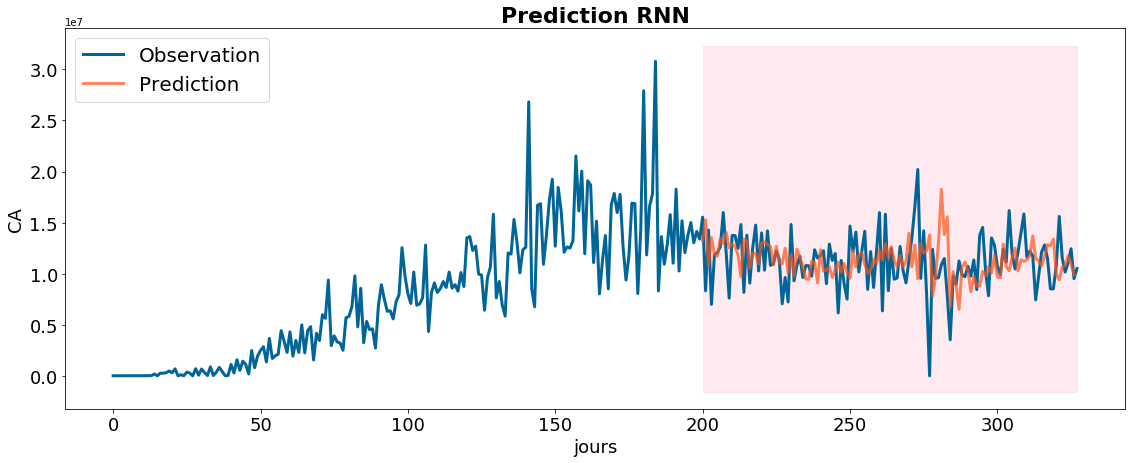

rmse = 3177229.5960255265


In [9]:
train_predict_plot = np.empty_like(ts)
train_predict_plot[:,] = np.nan
train_predict_plot[lags: len(train_predict) + lags,] = train_predict.reshape(179,)
 
test_predict_plot = np.empty_like(ts)
test_predict_plot[:,] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(ts)-1,] = test_predict.reshape(127,)
 
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(y[0:],color='#006699',linewidth = 3, label='Observation');
df_pred = pd.Series(pd.DataFrame(test_predict_plot).dropna().values.reshape(127,),pd.DataFrame(test_predict_plot).dropna().index)
df_pred.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.fill_betweenx(ax.get_ylim(), 200, y.index[-1], alpha=.3, zorder=-1, color='pink');
ax.set_xlabel('jours', fontsize=18)
ax.set_ylabel('CA', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction RNN', fontsize=22, fontweight="bold")
plt.savefig('./images/PredictionRNN.png')
plt.show()


rmse = math.sqrt(((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean())
print('rmse = '+ str(rmse))

## LSTM-RNN

In [10]:

np.random.seed(1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.DataFrame(ts))
train = dataset[0:192,]
test = dataset[192:,]
lags = 8
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
mdl = Sequential()
mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
test_score = math.sqrt(mean_squared_error(y_test[:,0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))


Epoch 1/100
 - 1s - loss: 0.0498
Epoch 2/100
 - 0s - loss: 0.0189
Epoch 3/100
 - 0s - loss: 0.0161
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0136
Epoch 6/100
 - 0s - loss: 0.0132
Epoch 7/100
 - 0s - loss: 0.0133
Epoch 8/100
 - 0s - loss: 0.0131
Epoch 9/100
 - 0s - loss: 0.0129
Epoch 10/100
 - 0s - loss: 0.0130
Epoch 11/100
 - 0s - loss: 0.0128
Epoch 12/100
 - 0s - loss: 0.0126
Epoch 13/100
 - 0s - loss: 0.0128
Epoch 14/100
 - 0s - loss: 0.0123
Epoch 15/100
 - 0s - loss: 0.0124
Epoch 16/100
 - 0s - loss: 0.0126
Epoch 17/100
 - 1s - loss: 0.0122
Epoch 18/100
 - 0s - loss: 0.0121
Epoch 19/100
 - 0s - loss: 0.0124
Epoch 20/100
 - 0s - loss: 0.0120
Epoch 21/100
 - 0s - loss: 0.0121
Epoch 22/100
 - 0s - loss: 0.0121
Epoch 23/100
 - 0s - loss: 0.0120
Epoch 24/100
 - 0s - loss: 0.0120
Epoch 25/100
 - 0s - loss: 0.0122
Epoch 26/100
 - 0s - loss: 0.0118
Epoch 27/100
 - 0s - loss: 0.0117
Epoch 28/100
 - 0s - loss: 0.0117
Epoch 29/100
 - 0s - loss: 0.0118
Epoch 30/100
 - 0s - lo

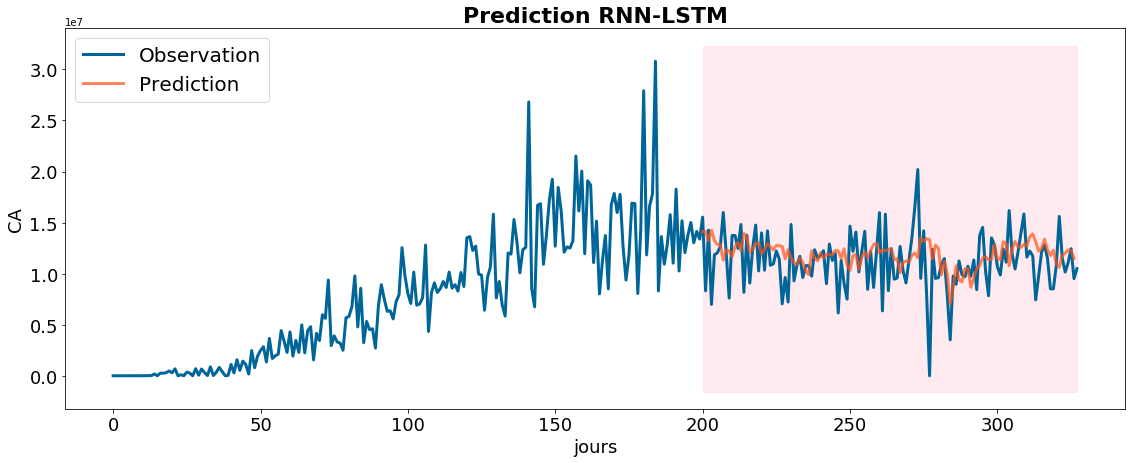

rmse = 2949959.3765315963


In [11]:
train_predict_plot = np.empty_like(ts)
train_predict_plot[:,] = np.nan
train_predict_plot[lags:len(train_predict)+lags,] = train_predict.reshape(183,)
 
test_predict_plot = np.empty_like(ts)
test_predict_plot[:,] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(ts)-1,] = test_predict.reshape(127,)
 
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(y[0:],color='#006699',linewidth = 3, label='Observation');
df_pred = pd.Series(pd.DataFrame(test_predict_plot).dropna().values.reshape(127,),pd.DataFrame(test_predict_plot).dropna().index)
df_pred.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.fill_betweenx(ax.get_ylim(), 200, y.index[-1], alpha=.3, zorder=-1, color='pink');
ax.set_xlabel('jours', fontsize=18)
ax.set_ylabel('CA', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction RNN-LSTM', fontsize=22, fontweight="bold")
plt.savefig('./images/PredictionRNN_LSTM.png')
plt.show()


rmse = math.sqrt(((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean())
print('rmse = '+ str(rmse))